# Mustererkennung/Machine Learning - Assignment 5 Solution

##### Questions to julian.stastny@fu-berlin.de

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

### Finding discrete maximum entropy distributions

In [2]:
class MaxEntropyOpimizer:
    
    def __init__(self, support_min_max, probs_std, exploration_std=0.001, iterations=100000):
        self.x, self.probs = self.probs_init(support_min_max)
        self.exploration_std = exploration_std
        self.iterations = iterations
        
    def plot_probs(self, title=None):
        plt.title(title)
        plt.bar(self.x, self.probs)
        plt.show()
        
    def fit(self):
        for i in range(self.iterations):    
            logits_candidate = np.log(self.probs) + np.random.normal(0, self.exploration_std, len(self.probs))
            probs_candidate = np.exp(logits_candidate)
            probs_candidate /= np.sum(probs_candidate)

            if self.lagrange(probs_candidate) >= self.lagrange(self.probs):
                self.probs = probs_candidate

            if i % int(self.iterations/10) == 0:
                p = self.probs
                x = self.x
                print("#{}, lagrange: {:02.3f}, prob std: {:02.3f}, var: {:02.3f}".format(
                    i, self.lagrange(p), p.std(), p @ (x - x @ p)**2))

                self.plot_probs(i)
    
    def var(self, mean=0):
        return self.probs @ (self.x - mean**2)
    
    def entropy(self, p):
        m = p >= 1e-10
        return - p[m] @ np.log(p[m])

    def probs_init(self, support_min_max, mu=1, std=0.2):
        x = np.arange(support_min_max[0], support_min_max[1])
        probs = np.clip(np.random.normal(mu, std, size=len(x)), 0, np.inf)
        probs /= np.sum(probs)
        return x, probs

In [3]:
class MaxEntropy(MaxEntropyOpimizer): # a
    
    def lagrange(self, p):
        return self.entropy(p) 

class MaxEntropyVar(MaxEntropyOpimizer): # b 
    
    def lagrange(self, p):
        return self.entropy(p) - 0.01 * (p @ (self.x**2) - (self.x @ p)**2)

#0, lagrange: 4.580, prob std: 0.002, var: 848.384


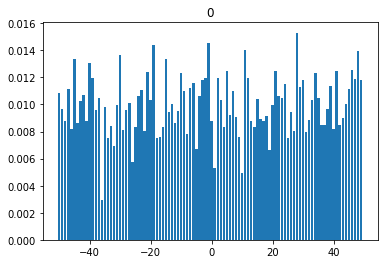

#2000, lagrange: 4.593, prob std: 0.002, var: 842.915


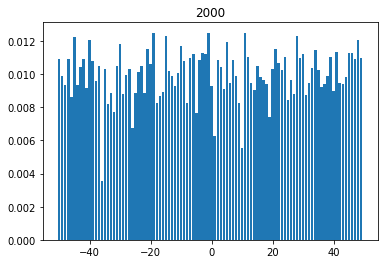

#4000, lagrange: 4.601, prob std: 0.001, var: 840.717


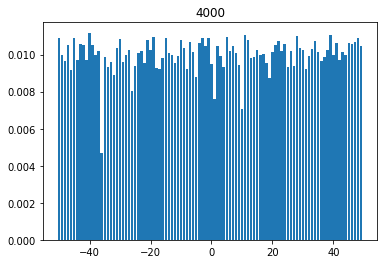

#6000, lagrange: 4.605, prob std: 0.000, var: 834.648


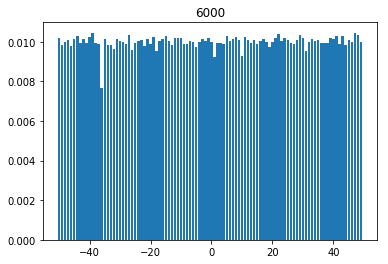

#8000, lagrange: 4.605, prob std: 0.000, var: 833.215


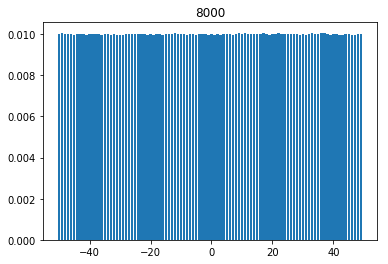

#10000, lagrange: 4.605, prob std: 0.000, var: 833.304


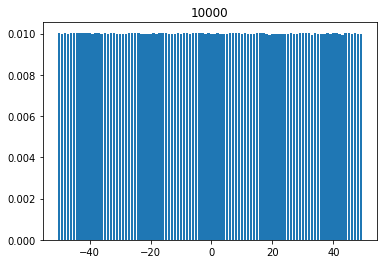

#12000, lagrange: 4.605, prob std: 0.000, var: 833.153


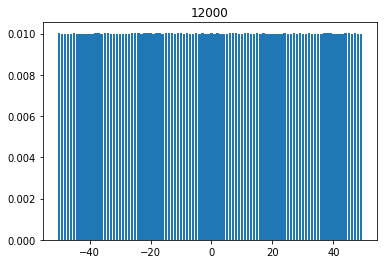

#14000, lagrange: 4.605, prob std: 0.000, var: 833.190


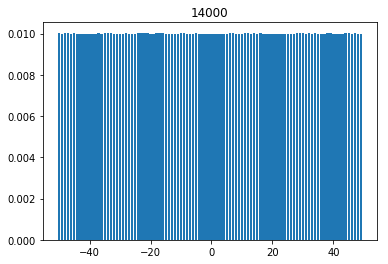

#16000, lagrange: 4.605, prob std: 0.000, var: 833.128


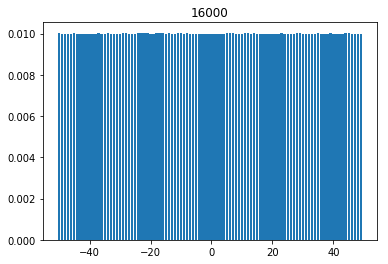

#18000, lagrange: 4.605, prob std: 0.000, var: 833.273


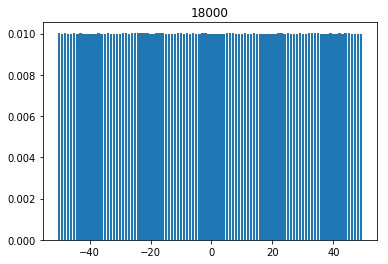

In [4]:
max_entr = MaxEntropy(support_min_max=(-50, 50), probs_std=0.2, iterations=20000)
max_entr.fit()

In [5]:
max_entr_mean_var = MaxEntropyVar(support_min_max=(-50, 50), probs_std=0.2, iterations=100000)

#0, lagrange: -3.564, prob std: 0.002, var: 815.197


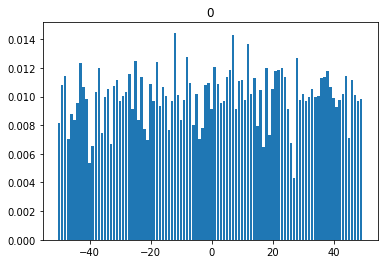

#10000, lagrange: -0.995, prob std: 0.005, var: 548.982


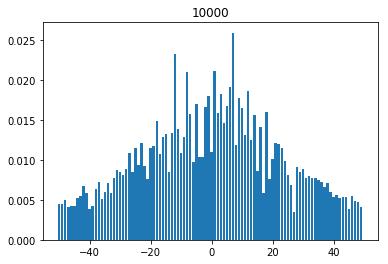

#20000, lagrange: 0.813, prob std: 0.009, var: 343.405


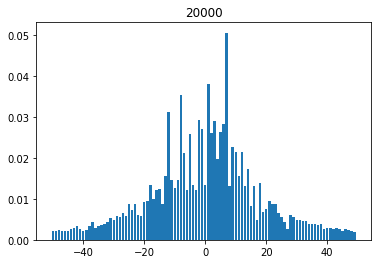

#30000, lagrange: 1.943, prob std: 0.015, var: 192.255


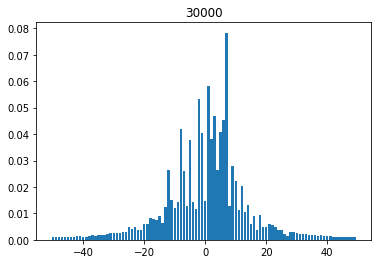

#40000, lagrange: 2.479, prob std: 0.017, var: 109.240


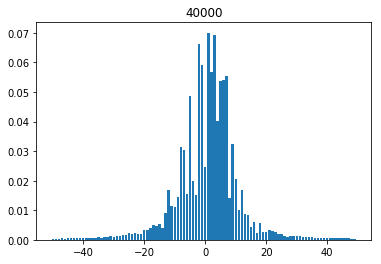

#50000, lagrange: 2.728, prob std: 0.018, var: 71.870


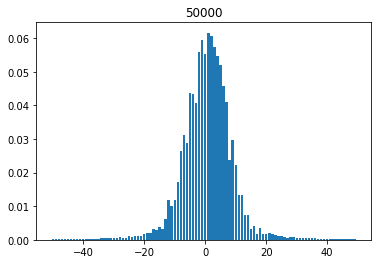

#60000, lagrange: 2.819, prob std: 0.018, var: 56.340


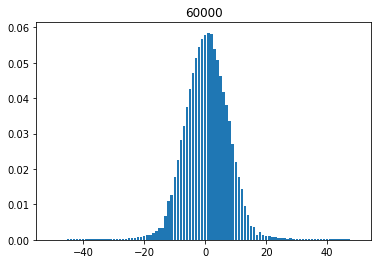

#70000, lagrange: 2.853, prob std: 0.018, var: 51.968


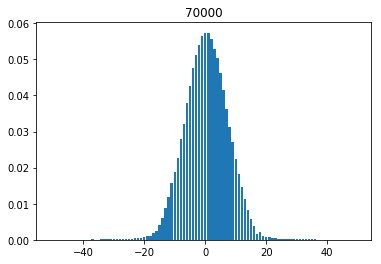

#80000, lagrange: 2.866, prob std: 0.017, var: 50.944


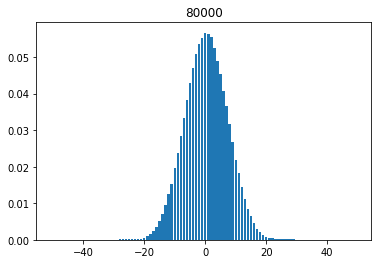

#90000, lagrange: 2.871, prob std: 0.017, var: 50.299


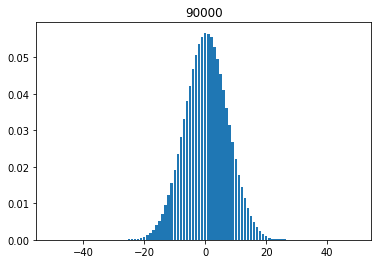

In [6]:
max_entr_mean_var.fit()

### Investigating the asymmetry of the KL-Divergence

In [7]:
probs = np.array([8.18384229e-10, 8.71684737e-09, 7.85976146e-08, 5.99938901e-07, 3.87661271e-06, 2.12053548e-05, 9.81943294e-05, 3.84924025e-04, 1.27735433e-03, 3.58835616e-03, 8.53350765e-03, 1.71793910e-02, 2.92776957e-02, 4.22393859e-02, 5.15892405e-02, 5.33453422e-02, 4.67166635e-02, 3.46980367e-02, 2.20031772e-02, 1.23034640e-02, 7.00001126e-03, 5.85445547e-03, 8.23730568e-03, 1.38403360e-02, 2.26071794e-02, 3.42340407e-02, 4.76800992e-02, 6.10068359e-02, 7.16992719e-02, 7.73994024e-02, 7.67443045e-02, 6.98940634e-02, 5.84682376e-02, 4.49247114e-02, 3.17056138e-02, 2.05528766e-02, 1.22375546e-02, 6.69271368e-03, 3.36198235e-03, 1.55122284e-03, 6.57413364e-04, 2.55910701e-04, 9.15005998e-05, 3.00500372e-05, 9.06466307e-06, 2.51156195e-06, 6.39177831e-07, 1.49411866e-07, 3.20799774e-08, 6.32657405e-09])

In [8]:
class KLMinimizer:
    
    def __init__(self, x, given_probs, probs_std=0.2, forward_kl=True, exploration_std=1, iterations=100000):
        self.mean = 0
        self.std = 4
        self.x = x
        self.given_probs = given_probs
        self.exploration_std = exploration_std
        self.iterations = iterations
        self.forward_kl = forward_kl
        
    def plot_probs(self, title=None):
        plt.title(title)
        plt.bar(self.x, self.given_probs, alpha=0.5, color='red')
        plt.bar(self.x, self.model_probs(), alpha=0.5)
        plt.show()
        
    def fit(self):
        for i in range(self.iterations):    
            noise = np.random.normal(0, self.exploration_std, size=1)
            mean = self.mean + noise
            noise = np.random.normal(0, self.exploration_std, size=1)
            std = self.std + noise
            
            probs_candidate = self.discrete_normal_probs(self.x, mean, std)

            if self.forward_kl:
                kl_model = self.kl_div(self.given_probs, self.model_probs())
                kl_candidate = self.kl_div(self.given_probs, probs_candidate)
            else:
                kl_model = self.kl_div(self.model_probs(), self.given_probs)
                kl_candidate = self.kl_div(probs_candidate, self.given_probs)
            if kl_candidate < kl_model:
                self.mean = mean
                self.std = std

            if i % int(self.iterations/10) == 0:
                p = self.model_probs()
                x = self.x
                print("#{}, kl: {:02.3f}, prob std: {:02.3f}, mean: {:02.3f}, var: {:02.3f}".format(
                    i, kl_model, p.std(), x @ p, p @ (x - x @ p)**2))

                self.plot_probs(i)
                
    def discrete_normal_probs(self, x, mu, sigma):
        dist = norm(mu, sigma)
        prob = dist.pdf(x)
        return prob
    
    def model_probs(self):
        return self.discrete_normal_probs(self.x, self.mean, self.std)

    def kl_div(self, p, q):
        m = p >= 1e-10
        return p[m] @ np.log2(p[m] / q[m])

#0, kl: 1.378, prob std: 0.032, mean: -0.000, var: 16.000


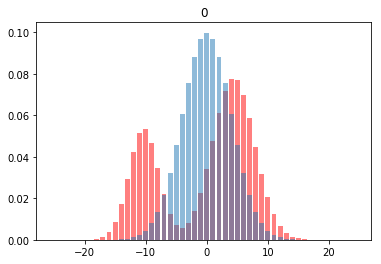

#1000, kl: 0.416, prob std: 0.018, mean: -0.445, var: 57.248


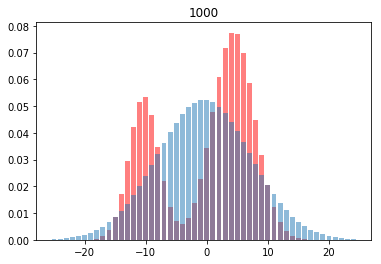

#2000, kl: 0.416, prob std: 0.018, mean: -0.445, var: 57.248


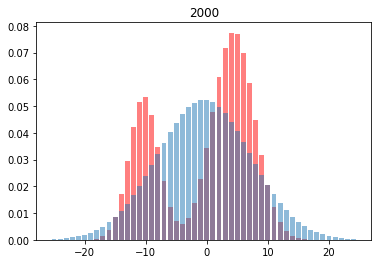

#3000, kl: 0.416, prob std: 0.019, mean: -0.432, var: 56.913


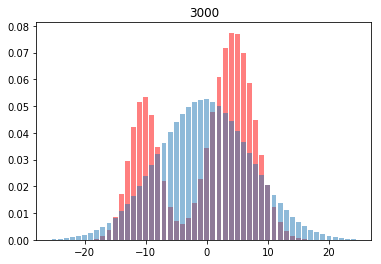

#4000, kl: 0.416, prob std: 0.019, mean: -0.432, var: 56.913


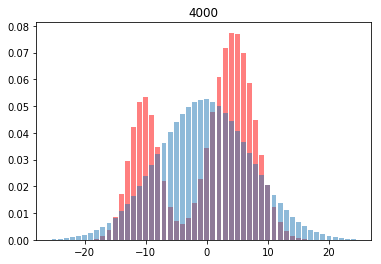

#5000, kl: 0.416, prob std: 0.019, mean: -0.432, var: 56.913


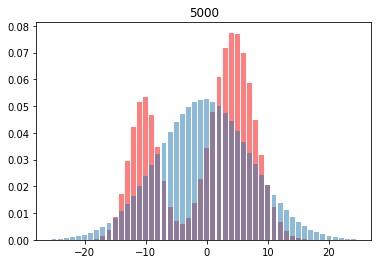

#6000, kl: 0.416, prob std: 0.019, mean: -0.432, var: 56.913


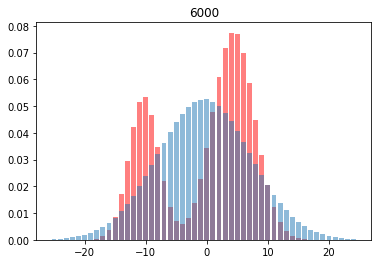

#7000, kl: 0.416, prob std: 0.019, mean: -0.432, var: 56.913


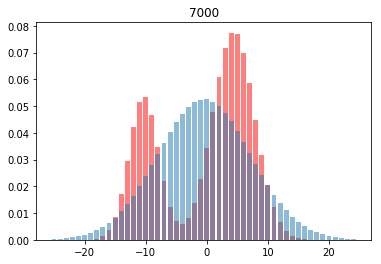

#8000, kl: 0.416, prob std: 0.019, mean: -0.432, var: 56.913


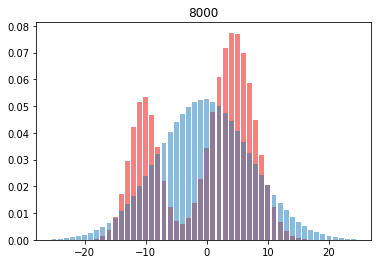

#9000, kl: 0.416, prob std: 0.019, mean: -0.432, var: 56.913


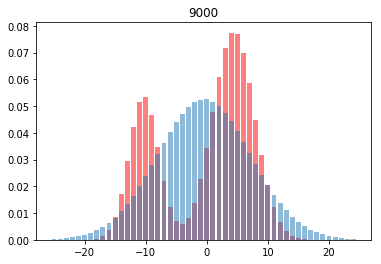

In [9]:
x = np.arange(-25, 25)
dkl_min_forward = KLMinimizer(x, probs, iterations=10000)
dkl_min_forward.fit()

#0, kl: 1.096, prob std: 0.032, mean: -0.000, var: 16.000


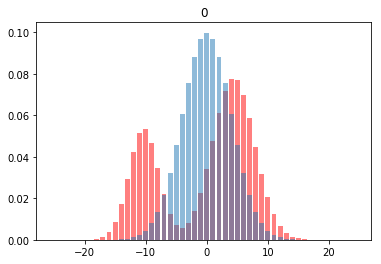

#1000, kl: 0.547, prob std: 0.033, mean: 4.095, var: 14.945


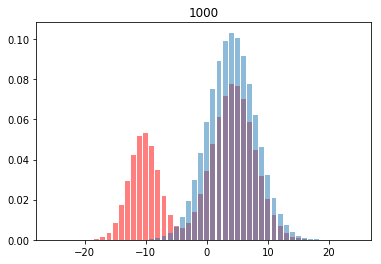

#2000, kl: 0.547, prob std: 0.033, mean: 4.095, var: 14.945


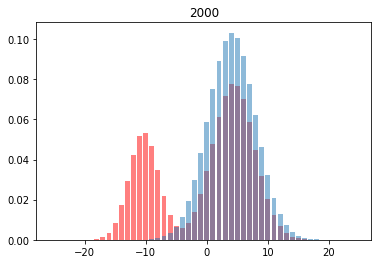

#3000, kl: 0.547, prob std: 0.033, mean: 4.046, var: 14.685


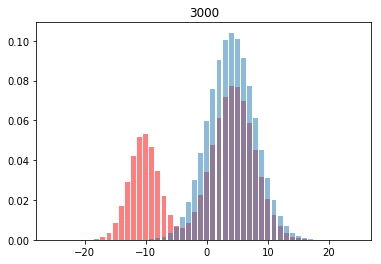

#4000, kl: 0.547, prob std: 0.033, mean: 4.046, var: 14.685


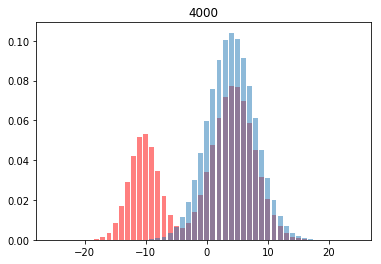

#5000, kl: 0.547, prob std: 0.033, mean: 4.046, var: 14.685


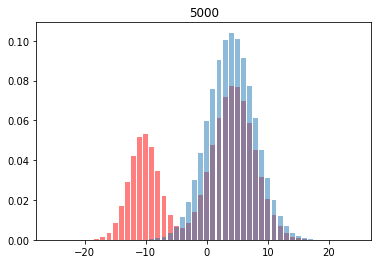

#6000, kl: 0.547, prob std: 0.033, mean: 4.046, var: 14.685


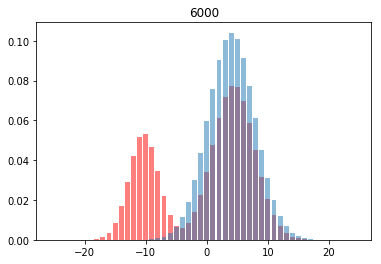

#7000, kl: 0.547, prob std: 0.033, mean: 4.092, var: 14.827


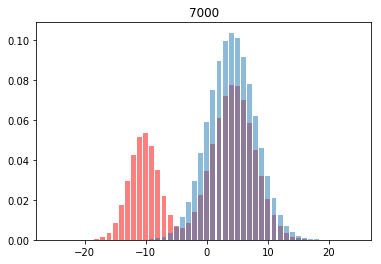

#8000, kl: 0.547, prob std: 0.033, mean: 4.092, var: 14.827


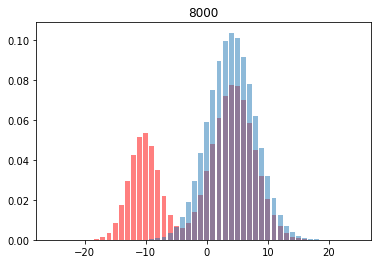

#9000, kl: 0.547, prob std: 0.033, mean: 4.100, var: 14.545


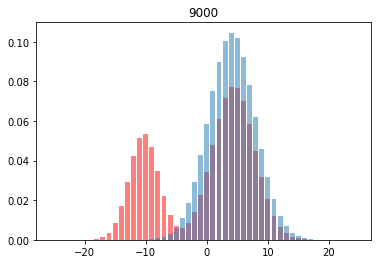

In [10]:
dkl_min_backward = KLMinimizer(x, probs, forward_kl=False, iterations=10000)
dkl_min_backward.fit()